In [1]:
import som
import numpy as np
import math
import time
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local").appName("MapaAutoorganizado").getOrCreate()
sc = spark.sparkContext

In [2]:
import numba
from numba import cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
import numpy as np

@cuda.jit
def rand_weights(rng_states, d_weights):
    """
    Kernel para inicializar aleatoriamente la 'matriz' de pesos con valores 
    en el intervalo [0, 1) tomados de una distribución aleatoria
    :param rng_states Estados aleatorios
    :param d_weigths Vector de M * N * d valores que contendrá los pesos asociados a las neuronas
    """
    idx = cuda.grid(1)
    # Cogemos índices para pasar de array unidimensional a tridimensional
    n_rows, n_cols, d = d_weights.shape
    row = idx // (n_cols * d)
    col_d = idx % (n_cols * d)
    col = col_d // d
    i = col_d % d
    
    # Sacamos el aleatorio correspondiente
    if idx < d_weights.size:
        d_weights[row, col, i] = xoroshiro128p_uniform_float32(rng_states, idx)
    

In [3]:
"""
Implementación de un único kernel para ser ejecutado en cada partición del RDD.
"""
@cuda.jit
def som_iter(d_samples, d_weights, d_nums, d_denums, sigma_squared):
    """
    Este kernel realiza el proceso de calcular las distancias euclídeas entre
    todas las muestras y los pesos de las neuronas. Encontrar la mejor BMU para
    una muestra y realizar el cálculo parcial de los pesos correspondientes.
    :param d_samples Conjunto de todas las muestras a evaluar.
    :param d_weights Array de filas * columnas * d valores con los pesos 
    asociados a cada una de las neuronas.
    :param d_distances Array de tamaño N * nneurons para almacenar
    las distancias
    :param d_nums Vector con los numeradores para el cálculo de la fórmula.
    :param d_denums Vector con los denominadores para el cálculo de la fórmula.
    :param sigma_squared Valor de sigma al cuadrado para el cáculo del vecindario.
    """
    # 0. Índices
    nrows, ncols, d = d_weights.shape
    nneurons = nrows * ncols
    
    
    sample_idx = cuda.blockIdx.x
    neuron_idx = cuda.threadIdx.x
    neuron_row = neuron_idx // ncols
    neuron_col = neuron_idx % ncols
    blockSize = cuda.blockDim.x
       
    # 0. Declaramos  e inicializamos la memoria compartida
    # Memoria compartida para guardar la muestra del bloque
    shared_sample = cuda.shared.array(shape=0, dtype=numba.float32)
    # Memoria compartida para guardar las distancias de cada muestra del bloque con
    # cada neurona (máximo 1024 neuronas).
    shared_distances = cuda.shared.array(shape=1024, dtype=numba.float32)
    # Memoria compartida para los índices de la reducción (máximo 1024 neuronas).
    shared_idx = cuda.shared.array(shape=1024, dtype=numba.int32)
    
    # 1. Empezamos calculando la distancia euclídea de la muestra con las neuronas
    #    del bloque.
    # 1.a Cargamos la muestra del bloque en memoria compartida 
    for i in range(d // nneurons + 1):
        i_stride = i * nneurons
        my_pos = i_stride + cuda.threadIdx.x
        if my_pos < d:
            shared_sample[my_pos] = d_samples[sample_idx, my_pos]
    
    
    cuda.syncthreads()
    
    # 1.b Calculamos las distancias euclídeas que nos corresponden.
    # Aprovechamos la barrera al final de la operación para inicializar la
    # memoria compartida para la reducción.
    
    if neuron_idx < nneurons:
        shared_distances[neuron_idx] = 0.0
        for i in range(d):
            i_distance = shared_sample[i] - d_weights[neuron_row, neuron_col, i]
            shared_distances[neuron_idx] += i_distance * i_distance
    else:
        shared_distances[neuron_idx] = np.inf
    
    # Inicializamos el array de índices para la reducción.
    shared_idx[neuron_idx] = neuron_idx
    cuda.syncthreads()
    
    
    # 2. Realizamos la reducción para encontrar la mejor distancia.
    
    # Unroll de bloque
    if blockSize >= 1024 and neuron_idx < 512:
        if shared_distances[neuron_idx + 512] < shared_distances[neuron_idx]:
            shared_distances[neuron_idx] = shared_distances[neuron_idx + 512]
            shared_idx[neuron_idx] = shared_idx[neuron_idx + 512]
    cuda.syncthreads()
    
    if blockSize >= 512 and neuron_idx < 256:
        if shared_distances[neuron_idx + 256] < shared_distances[neuron_idx]:
            shared_distances[neuron_idx] = shared_distances[neuron_idx + 256]
            shared_idx[neuron_idx] = shared_idx[neuron_idx + 256]
    cuda.syncthreads()
    
    if blockSize >= 256 and neuron_idx < 128:
        if shared_distances[neuron_idx + 128] < shared_distances[neuron_idx]:
            shared_distances[neuron_idx] = shared_distances[neuron_idx + 128]
            shared_idx[neuron_idx] = shared_idx[neuron_idx + 128]
    cuda.syncthreads()
    
    if blockSize >= 128 and neuron_idx < 64:
        if shared_distances[neuron_idx + 64] < shared_distances[neuron_idx]:
            shared_distances[neuron_idx] = shared_distances[neuron_idx + 64]
            shared_idx[neuron_idx] = shared_idx[neuron_idx + 64]
    cuda.syncthreads()
    
    # Unroll de warp
    if neuron_idx < 32:
        if shared_distances[neuron_idx + 32] < shared_distances[neuron_idx]:
            shared_distances[neuron_idx] = shared_distances[neuron_idx + 32]
            shared_idx[neuron_idx] = shared_idx[neuron_idx + 32]
        if shared_distances[neuron_idx + 16] < shared_distances[neuron_idx]:
            shared_distances[neuron_idx] = shared_distances[neuron_idx + 16]
            shared_idx[neuron_idx] = shared_idx[neuron_idx + 16]
        if shared_distances[neuron_idx + 8] < shared_distances[neuron_idx]:
            shared_distances[neuron_idx] = shared_distances[neuron_idx + 8]
            shared_idx[neuron_idx] = shared_idx[neuron_idx + 8]
        if shared_distances[neuron_idx + 4] < shared_distances[neuron_idx]:
            shared_distances[neuron_idx] = shared_distances[neuron_idx + 4]
            shared_idx[neuron_idx] = shared_idx[neuron_idx + 4]
        if shared_distances[neuron_idx + 2] < shared_distances[neuron_idx]:
            shared_distances[neuron_idx] = shared_distances[neuron_idx + 2]
            shared_idx[neuron_idx] = shared_idx[neuron_idx + 2]
        if shared_distances[neuron_idx + 1] < shared_distances[neuron_idx]:
            shared_distances[neuron_idx] = shared_distances[neuron_idx + 1]
            shared_idx[neuron_idx] = shared_idx[neuron_idx + 1]
    
    cuda.syncthreads()
    
    # La mejor distancia se encuentra en la posición 0 del array.
    bmu = shared_idx[0]
    bmu_row = bmu // ncols
    bmu_col = bmu % ncols

    cuda.syncthreads()
    # 3. Realizamos la actualización de los pesos.
    if neuron_idx < nneurons:
        dist = (neuron_row - bmu_row) * (neuron_row - bmu_row) + \
               (neuron_col - bmu_col) * (neuron_col - bmu_col)
        # Si estamos dentro del rango de actualización.
        if dist <= sigma_squared:
            hck = math.exp(-dist/(2 * sigma_squared))
            # Guardamos sumatoria del denominador
            cuda.atomic.add(d_denums, neuron_row * ncols + neuron_col, hck)
            # Guardamos sumatoria del numerador
            for i in range(d):
                cuda.atomic.add(d_nums, neuron_row*ncols*d + neuron_col*d+i,
                                hck * shared_sample[i])


In [4]:
@cuda.jit
def finish_update(d_weights, partials, numParts):
    """
    Este kernel terminas las sumas parciales.
    Se ejecuta en un único nodo de Spark.
    
    :param d_weights Array de pesos de neuronas
    :param partials Array con sumas parciales
    :param numParts Número de resultados parciales a procesar.
    """
    idx = cuda.grid(1)
    nrows, ncols, d = d_weights.shape
    if idx < nrows * ncols:
        row = idx // ncols
        col = idx % ncols
        
        # a) Sumamos todos los parciales en el primer array
        numsize = nrows * ncols * d
        densize = nrows * ncols
        fullsize = numsize + densize
        for i in range(numParts - 1):
            # Suma de numeradores
            for k in range(d):
                pos = fullsize * i + row * ncols * d + col * d + k
                partials[row * ncols * d + col * d + k] += partials[pos]
            # Suma de denominadores
            pos = fullsize * i + numsize + row * ncols + col
            partials[numsize + row * ncols + col] += partials[pos]
    
        # b) Si no es 0 el denominador realizamos la división y cambiamos pesos actuales
        if partials[numsize + row * ncols + col] != 0:
            for k in range(d):
                d_weights[row, col, k] = partials[row*ncols*d + col*d +k] / \
                                         partials[numsize + row * ncols + col]


In [5]:
"""
Spark con GPU
"""
def gpu_work_iter(weights, sigma_squared):
    # Declarada función interna para devolverla y poder utilizar
    # múltiples parámetros al llamar a mapPartitions
    def _gpu_work(data):
        # 1. Procesamos el dataset
        inp = np.asarray(list(data), dtype=np.float32)
        rows, cols, d = weights.shape
        nneurons = rows * cols
        N = inp.shape[0]
    
        # 2. Pasamos los datos a las memorias del dispositivo
        d_samples = cuda.to_device(inp)
        d_weights = cuda.to_device(weights)
        nums = np.zeros(rows * cols * d, np.float32)
        denums = np.zeros(rows * cols, np.float32)
        d_nums = cuda.to_device(nums)
        d_denums = cuda.to_device(denums)
        
        # 3. Tomamos el número de hebras por bloque
        if nneurons > 1024:
            raise Exception('Número de neuronas superior al límite')
        
        tpb = max(64,2**(math.ceil(math.log2(nneurons))))
            
        # 3. Lanzamos el kernel.
        sm_size = 4 * d # Memoria compartida para almacenar una muestra por bloque
        som_iter[N, tpb, 0, sm_size](d_samples, d_weights, d_nums, d_denums, sigma_squared)
        
        return d_nums.copy_to_host(), d_denums.copy_to_host()
    return _gpu_work

In [6]:
def spark_gpu_batch_som(rdd_data, d, max_iters, rows, cols, smooth_iters=None, sigma_0=10, 
                          sigma_f=0.1, tau=400, seed=None, tpb=128):
    
    # 1. Inicializamos pesos aleatorios
    d_weights = cuda.device_array((rows, cols ,d), np.float32)
    rng_states = create_xoroshiro128p_states(rows * cols * d, seed=seed)
    rand_weights[(d_weights.size) // tpb + 1, tpb](rng_states, d_weights)
     
    weights = d_weights.copy_to_host()
    # 2. Bucle del algoritmo
    for t in range(max_iters):
        # 2.a Actualizamos los parámetros de control si procede
        if smooth_iters is None or t < max_iters:
            sigma = sigma_0 * math.exp((-t/tau))
        else:
            sigma = sigma_f
            
        sigma_squared = sigma * sigma
        
        # 2.b Cada nodo del clúster de spark trabajará con un subconjunto
        # de las muestras del RDD para encontrar la BMU y realizar la suma
        # parcial de su ecucación de actualización de pesos
        out = rdd_data.mapPartitions(gpu_work_iter(weights, sigma_squared))
        
        # 2.c En un único nodo usamos la GPU para juntar todas las sumas parciales obtenidas
        #   y realizar la división
        out = out.collect()
        numParts = len(out) // 2

        partials = np.concatenate(out)
        finish_update[rows * cols // tpb + 1, tpb](weights, partials, numParts)
       
    return weights



In [38]:
"""
Ejemplo de las caras
"""
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
    
faces = fetch_olivetti_faces()['data']
rows = 5
cols = 6
d=faces.shape[1]
iters = 50
smooth_iters = 25
sigma_0 = 3
tau = 50
multiprocessors = 10
rdd_faces = sc.parallelize(faces).repartition(multiprocessors).cache()
data = rdd_faces.collect()

In [45]:
inicio = time.time()
weights=spark_gpu_batch_som(rdd_faces, d, iters, rows, cols, smooth_iters, sigma_0, 0.1, tau, seed=2)
fin = time.time()

GPU
Tiempo ejecución (s) 295.22381615638733
Error de cuantificación: 6.556586507558823
Error topográfico: 0.0125


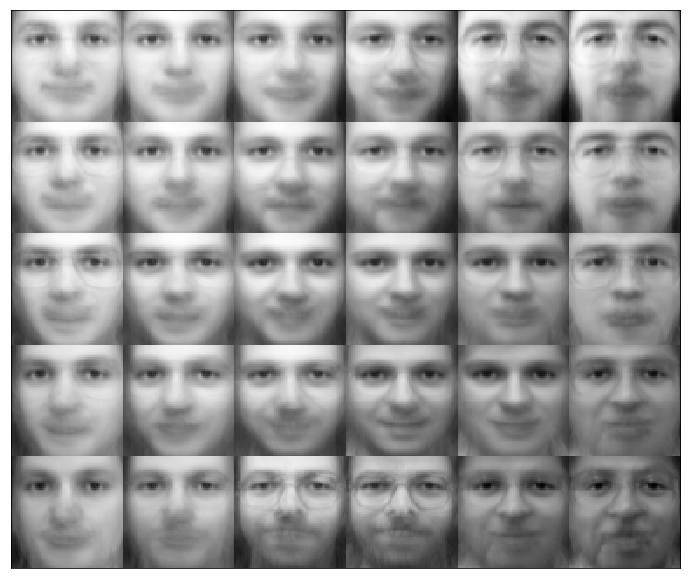

In [40]:
def pintar(texto, pesos):
    W = pesos
    pattern_length = faces.shape[1]
    pattern_width = pattern_height = int(np.sqrt(pattern_length))
    matrix_w = np.empty((rows * pattern_height, cols * pattern_width))


    for i in range(rows):
        for j in range(cols):
            matrix_w[i * pattern_height:i * pattern_height + pattern_height, 
    j * pattern_height:j * pattern_height + pattern_width] = W[i, j].reshape((pattern_height, pattern_width)) * 255.0
    fig, ax = plt.subplots(figsize=(12,12))

    ax.matshow(matrix_w.tolist(), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    print(texto)
    print('Tiempo ejecución (s)', fin - inicio)
    print('Error de cuantificación:', som.quantification_error(faces, weights) )
    print('Error topográfico:', som.topography_error(faces, weights))
    plt.show()
pintar('GPU', weights)

In [10]:
inicio = time.time()
weights = som.spark_cpu_batch_som(rdd_faces, d, iters, rows, cols, smooth_iters, sigma_0, 0.1, tau, seed=2)
fin = time.time()

CPU
Tiempo ejecución (s) 203.08935570716858
Error de cuantificación: 6.571182821291246
Error topográfico: 0.0325


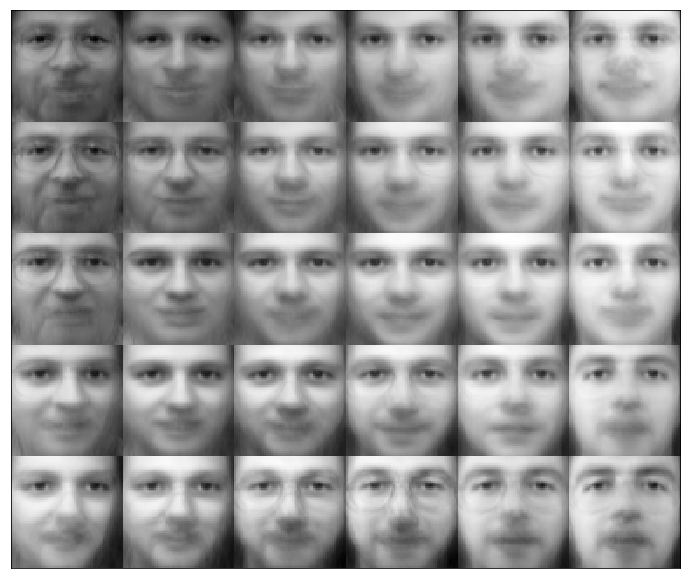

In [11]:
pintar('CPU', weights)

In [8]:
"""
Experimento con SUSY.
"""
d = 18
rows = 8
cols = 7
tau = 10
smooth_iters = 5
max_iters = 10
sigma_0 = 4

from pyspark.ml.linalg import DenseVector
from pyspark.ml.feature import StandardScaler
from pyspark.sql import Row

multiprocessors = 2
rdd = sc.textFile('../datasets/SUSY.csv').repartition(multiprocessors)
rdd = rdd.map(lambda line: line.split(','))
rdd = rdd.map(lambda line: Row(features=DenseVector(line[1:])))
df = rdd.toDF()
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)
scalerModel = scaler.fit(df)
normalized_df = scalerModel.transform(df)
rdd = normalized_df.rdd
rdd = rdd.map(lambda line: np.float32(line.scaledFeatures))

In [11]:
def subsample_and_repeat(sub_percent, rdd, repeat=5):
    subrdd = rdd.sample(True, sub_percent, seed=7).cache()
    a = subrdd.take(1)
    for my_iter in range(repeat):
        print('REPETICIÓN', my_iter)
        """
        inicio = time.time()
        cpu_weights=som.spark_cpu_batch_som(subrdd, d, max_iters, rows, cols,  smooth_iters, sigma_0, 0.1, tau, seed=my_iter)
        fin = time.time()
        print('TIEMPO CPU', fin - inicio)
        """
        inicio = time.time()
        weights=spark_gpu_batch_som(subrdd, d, max_iters, rows, cols, smooth_iters, sigma_0, 0.1, tau, seed=my_iter)
        fin = time.time()
        print('TIEMPO GPU', fin - inicio)
    subrdd.unpersist()

In [12]:
subsample_and_repeat(0.1, rdd)

REPETICIÓN 0
TIEMPO GPU 110.3695707321167
REPETICIÓN 1
TIEMPO GPU 23.90082812309265
REPETICIÓN 2
TIEMPO GPU 23.995606422424316
REPETICIÓN 3
TIEMPO GPU 24.06605839729309
REPETICIÓN 4
TIEMPO GPU 24.09696388244629


In [13]:
subsample_and_repeat(0.2, rdd)

REPETICIÓN 0
TIEMPO GPU 109.58905291557312
REPETICIÓN 1
TIEMPO GPU 28.30241823196411
REPETICIÓN 2
TIEMPO GPU 28.3778133392334
REPETICIÓN 3
TIEMPO GPU 28.595502853393555
REPETICIÓN 4
TIEMPO GPU 28.50895595550537


In [14]:
subsample_and_repeat(0.3, rdd)

REPETICIÓN 0
TIEMPO GPU 114.50975632667542
REPETICIÓN 1
TIEMPO GPU 32.61866617202759
REPETICIÓN 2
TIEMPO GPU 32.66662263870239
REPETICIÓN 3
TIEMPO GPU 32.52477192878723
REPETICIÓN 4
TIEMPO GPU 32.47895622253418


In [15]:
subsample_and_repeat(0.4, rdd)

REPETICIÓN 0
TIEMPO GPU 118.36406087875366
REPETICIÓN 1
TIEMPO GPU 36.489156007766724
REPETICIÓN 2
TIEMPO GPU 36.39170169830322
REPETICIÓN 3
TIEMPO GPU 36.11613368988037
REPETICIÓN 4
TIEMPO GPU 36.38654828071594


In [16]:
subsample_and_repeat(0.5, rdd)

REPETICIÓN 0
TIEMPO GPU 122.49476599693298
REPETICIÓN 1
TIEMPO GPU 40.18300199508667
REPETICIÓN 2
TIEMPO GPU 40.09276008605957
REPETICIÓN 3
TIEMPO GPU 40.182746171951294
REPETICIÓN 4
TIEMPO GPU 41.759865283966064


In [17]:
subsample_and_repeat(0.6, rdd)

REPETICIÓN 0
TIEMPO GPU 127.18713879585266
REPETICIÓN 1
TIEMPO GPU 43.38971948623657
REPETICIÓN 2
TIEMPO GPU 43.733232736587524
REPETICIÓN 3
TIEMPO GPU 44.048720598220825
REPETICIÓN 4
TIEMPO GPU 44.27454924583435


In [18]:
subsample_and_repeat(0.7, rdd)

REPETICIÓN 0
TIEMPO GPU 128.31997108459473
REPETICIÓN 1
TIEMPO GPU 46.80463147163391
REPETICIÓN 2
TIEMPO GPU 46.78058671951294
REPETICIÓN 3
TIEMPO GPU 47.028987407684326
REPETICIÓN 4
TIEMPO GPU 47.54728078842163


In [19]:
subsample_and_repeat(0.8, rdd)

REPETICIÓN 0
TIEMPO GPU 132.0697476863861
REPETICIÓN 1
TIEMPO GPU 50.080047607421875
REPETICIÓN 2
TIEMPO GPU 50.03555750846863
REPETICIÓN 3
TIEMPO GPU 50.265751361846924
REPETICIÓN 4
TIEMPO GPU 50.904685735702515


In [23]:
subsample_and_repeat(0.9, rdd)

REPETICIÓN 0
TIEMPO GPU 133.2318274974823
REPETICIÓN 1
TIEMPO GPU 52.65623617172241
REPETICIÓN 2
TIEMPO GPU 52.69547891616821
REPETICIÓN 3
TIEMPO GPU 52.3542582988739
REPETICIÓN 4
TIEMPO GPU 52.75818157196045


In [22]:
subsample_and_repeat(1.0, rdd)

REPETICIÓN 0
TIEMPO GPU 137.49365997314453
REPETICIÓN 1
TIEMPO GPU 55.24388647079468
REPETICIÓN 2
TIEMPO GPU 55.52290678024292
REPETICIÓN 3
TIEMPO GPU 55.447476387023926
REPETICIÓN 4
TIEMPO GPU 55.41945195198059
